In [66]:
%reset

##### Copyright 2020 Kyu Sang Han

In [67]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Deep Learning on TensorFlow  
<img src="imagesource/what.gif" width="400"/>

## What is image?
Image is grid of numbers. Each cell in the grid is called pixel.  
<img src="imagesource/pixel.png" width="500"/>  
When you have layers of RGB (Red, Green, Blue), you can make a color image.  
<img src="imagesource/rgb1.png" width="400"/><img src="imagesource/rgb2.png" width="200"/>   

## What is deep learning?
<img src="imagesource/whatpeople.png" width="500"/>

**What you guys think I do:**  
<img src="imagesource/deeplearningblackbox.png" width="500"/>  

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, GlobalAveragePooling2D, add,average,maximum
from tensorflow_docs import modeling
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
tfds.disable_progress_bar() # disable tqdm progress bar

<img src="imagesource/pika.jpg" width="300"/>

In [69]:
print("TensorFlow Version: ",tf.__version__)
print("Number of GPU available: ",len(tf.config.experimental.list_physical_devices("GPU")))

TensorFlow Version:  2.1.0
Number of GPU available:  2


<img src="imagesource/rtx.png" width="500"/><img src="imagesource/mypc.jpg" width="300"/>

In [70]:
# 0. receive path of a folder containing an image file
# 1. extract label from folder
# 2. decode and convert image dtype
# 3. return image and label
def read_and_label(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  label = get_label(file_path)
  # img,label=augment(img,label)
  return img, label

In [71]:
# 0. receive JPEG-encoded image
# 1. decode image to a uint8 tensor
# 2. convert uint8 to float32 tensor
# 3. resize image tensor to match our model's preferred input size
# 4. return
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

JPEG is a method that makes grid of numbers look like grid of colors.  
<img src="imagesource/imagematrix.jpg" width="600"/>

In [72]:
# 0. receives path of a folder containing an image file
# 1. extract name of subfolders
# 2. return index of matching label in CLASS_NAMES list of labels
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.reshape(tf.where(parts[-4] == CLASS_NAMES),[])

In [73]:
# import tensorflow as tf
# import numpy as np
# import pathlib
# import os
# data_dir=r'C:\Users\kuki\Desktop\Research\Skin\RCNN data\train'
# data_dir = pathlib.Path(data_dir)
# CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_store"])
# file_path=r"C:\Users\kuki\Desktop\Research\Skin\RCNN data\train\old\sec071\image\1.jpg"
# parts = tf.strings.split(file_path, os.path.sep)
# print(tf.reshape(tf.where(parts[-4] == CLASS_NAMES),[]))

<img src="imagesource/getlabel.png" width="300"/>

In [74]:
# 0. receive an image tensor
# 1. perform augmentation
# 2. return augmented image
def augment(image,label):
  image = tf.image.random_hue(image, max_delta=0.1, seed=5)
  image = tf.image.random_contrast(image, 0.9, 1.1, seed=5) # tissue quality
  image = tf.image.random_saturation(image, 0.9, 1.1, seed=5) # stain quality
  image = tf.image.random_brightness(image, max_delta=0.1) # tissue thickness, glass transparency (clean)
  image = tf.image.random_flip_left_right(image, seed=5) # cell orientation
  image = tf.image.random_flip_up_down(image, seed=5) # cell orientation
  image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # cell orientation
  return image,label

<img src="imagesource/augment.jpg" width="500"/>

In [75]:
# list location of all training images
data_dir=r'C:\Users\kuki\Desktop\Research\Skin\RCNN data\train'
data_dir = pathlib.Path(data_dir)
train_image_count = len(list(data_dir.glob('*\*\image\*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_store"])
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/image/*'))
# To see what's inside of list_ds, use .take(n) and iterate through it.
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\train\\young\\sec001\\image\\109.jpg'
b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\train\\old\\sec068\\image\\1403.jpg'
b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\train\\old\\sec062\\image\\1046.jpg'
b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\train\\old\\sec068\\image\\1354.jpg'
b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\train\\old\\sec062\\image\\1751.jpg'


**Hyperparameter #0: Image Size**

Image size determines the area of view and how much context to be included in classification.

In [76]:
IMG_HEIGHT = 100
IMG_WIDTH = 100

**Parallel Data Input**

Data I/O may be a bottleneck of your workflow. Prefetching is to read data for next step while model is
executing current training step. Autotune will be used to determine the number of data to prefetch, which should be
greater than data needed for next step and smaller than RAM memory size.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

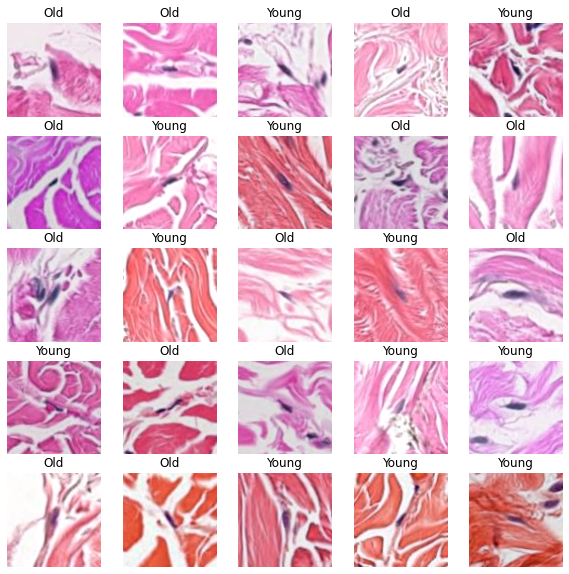

In [77]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
plt.figure(figsize=(10,10))
for idx,elem in enumerate(labeled_ds.take(25)):
    img = elem[0]
    label = elem[1]
    ax = plt.subplot(5,5,idx+1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label].title())
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

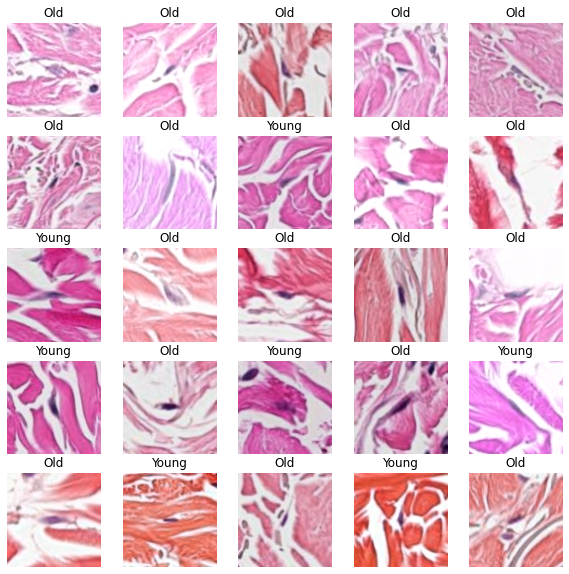

In [78]:
test_data_dir=r'C:\Users\kuki\Desktop\Research\Skin\RCNN data\test'
test_data_dir = pathlib.Path(test_data_dir)
test_image_count = len(list(test_data_dir.glob('*\*\image\*.jpg')))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*\*\image\*'))
test_labeled_ds = test_list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
plt.figure(figsize=(10,10))
for idx,elem in enumerate(test_labeled_ds.take(25)):
    img = elem[0]
    label = elem[1]
    ax = plt.subplot(5,5,idx+1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label].title())
    plt.axis('off')

In [14]:
BATCH_SIZE = 32

**Hyperparameter #1: Batch Size**

**What is it?**
- Number of image to be grouped together as a batch. Why batch? Because we cannot fit all images in GPU memory

**What does it do?**
- Ex) Batch_size of 400 will split 1000 training images into 3 batches containing 400,400,200 images

**Increase?**
- More accurate gradient descent because the direction of gradient step is based on more data.
- Limited by GPU memory
- Slow iteration speed
- Get stuck at local minima in Gradient landscape by descending too accurately, and not jumping around.

<img src="imagesource/dataset.png" width="300"/>

In [15]:
val_fraction = 10
val_image_count = test_image_count//100 * val_fraction # // : floor division ex) 15/2 = 7.5 -> 7
test_image_count2 = test_image_count - val_image_count

STEPS_PER_EPOCH = train_image_count//BATCH_SIZE
TEST_STEPS = test_image_count2 // BATCH_SIZE

**Hyperparameter #2: Steps per epoch**

**What is it?**
- Max number of batches within epoch (1 cycle of training)

**What does it do?**
- Ex) When you have 10 batches, each epoch is supposed to iterate 10 batches.
By setting steps per epoch to 5, you can only iterate 5 batches in one epoch.
To use all batches available, simply divide total image count by batch size,
just how it is set in this tutorial.

In [16]:
VALIDATION_STEPS = val_image_count // BATCH_SIZE

**Hyperparameter #3: Validation steps**

**What is it?**
- Same as steps per epoch, but for validation set

**What does it do?**
- Same as steps per epoch

## Train, Validation, Test Dataset  
Train and Test dataset are two independent group of images (e.g. different patients)
Validation dataset is subset of train we use during training to evaluate training is going in the right direction.
(e.g. train until validation loss does not improve).  
**Loss**: A measure of how far a model's predictions are from correct labels. Or, a measure of how bad the model is  
<img src="imagesource/getlabel.png" width="300"/><img src="imagesource/dataset.png" width="300"/>

**Question: Train until validation loss does not improve? When do you stop training?**  
We feed our entire training dataset to blackbox not just once, but multiple times.  
Feeding entire set once is called one **epoch**.

**Question: Why can't it finish learning in one epoch?**  
Why do you need to study same thing over and over again for the exam? AT least, you can set learning rate for the blackbox, but you can't set learning rate for yourself. XD

**Goal of training is to reduce the loss**  
<img src="imagesource/losscurve.png" width="400"/><img src="imagesource/lossland.jpg" width="400"/>

In [17]:
shuffle_buffer_size = 3000 #take first 100 from dataset and shuffle and pick one.
train_ds = (labeled_ds
#             .skip(val_image_count)
            .cache("./cache/fibro_train.tfcache")
            .shuffle(buffer_size=shuffle_buffer_size)
            .repeat()
            .batch(BATCH_SIZE)
            .map(augment, num_parallel_calls=AUTOTUNE) #always batch before mapping
            .prefetch(buffer_size=AUTOTUNE) 
            )

# no shuffle, augment for validation and test dataset
val_ds= (test_labeled_ds
               .shuffle(buffer_size=shuffle_buffer_size)
               .take(val_image_count)
               .cache("./cache/fibro_val.tfcache")
               .repeat()
               .batch(BATCH_SIZE)
               .prefetch(buffer_size=AUTOTUNE))

In [18]:
test_ds = (test_labeled_ds
            .cache("./cache/fibro_test.tfcache")
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE) #time it takes to produce next element
            )

### Transfer Learning
#### Tensorflow Hub

## What's inside of the blackbox?
<img src="imagesource/buildmodel.jpg" width="400"/>  

In [19]:
mobilenetv2 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(2, activation='softmax')
])
mobilenetv2.build([None, 100, 100, 3])  # Batch input shape.

In [20]:
mobilenetv2_train = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
                   trainable=True),  # Can be True, see below.
    tf.keras.layers.Dense(2, activation='softmax')
])
mobilenetv2_train.build([None, 100, 100, 3])  # Batch input shape.

### Convolutional Neural Network Architecture 
- Input layer = define the input image size  
![title](imagesource/conv1.png)
- Convolution layer = slide filter across image and compute dot product between filter and image  
![title](imagesource/conv3.png)  
<img src="imagesource/conv.png" width="400"/><img src="imagesource/mapdepth.png" width="400"/>

- Activation layer = apply non-linearity to feature map. "ReLU" set all negative values to zero in feature map.  

<img src="imagesource/activation.png" width="400"/>  

- Pooling layer = down-sample the activation map to keep important learned activation and remove fine detail. It prevents over-fitting. Almost always down-sample each dimension by half, creating 1/4 size of original activation map. By reducing resolution, activation map is free from local variance. 

<img src="imagesource/maxpool.png" width="400"/><img src="imagesource/avgpool.png" width="400"/>

- Fully-connected layer = flatten 2D activation maps to 1D and compute prediction score, a.k.a. logits.

In [21]:
model_cnnA1= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2) #young vs old
])

**Hyperparameter #4: Number of convolution filters**  
**Hyperparameter #5: Filter size**  
**Hyperparameter #6: Activation function**  
**Hyperparameter #7: Shape of fully connected layer**  

In [22]:
model_cnnA2= Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)
           ,kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    MaxPool2D((2, 2)),
    Dropout(0.5),
    Conv2D(32, (3, 3), activation='relu',
           kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',
           kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu',
           kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(2)
])

**Hyperparameter #8: Initializer**  
<img src="imagesource/lossland.jpg" width="400"/>  
**Hyperparameter #9: Regularizer**  
<!-- <img src="imagesource/regularizer_effect.jpg" width="400"/>   -->
**Hyperparameter #10: Dropout rate**  
<img src="imagesource/drop.png" width="400"/>  

In [23]:
model_cnnA3= Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(4, (3, 3), activation='relu'),
    Conv2D(16,(3, 3), activation='relu'),
    Conv2D(16,(3, 3), activation='relu'),
    Conv2D(32,(3, 3), activation='relu'),
    Conv2D(32,(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64,(3, 3), activation='relu'),
    Conv2D(64,(3, 3), activation='relu'),
    Conv2D(64,(3, 3), activation='relu'),
    Conv2D(64,(3, 3), activation='relu'),
    Conv2D(64,(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64,(3, 3), activation='relu'),
    Conv2D(64,(3, 3), activation='relu'),
    Conv2D(64,(3, 3), activation='relu'),
    Conv2D(64,(3, 3), activation='relu'),
    Conv2D(64,(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2) #young vs old
])

**Keras Functional API**

To build more advanced CNN, we need to use techniques like parallel convolution layers in Inception.
Or, residual connection used in ResNet. Sequential function we used in models above can only stack
layers in a single sequence. Below is an example of building the same model as above, but using Keras
Functional API syntax.

In [24]:
inputlayer = tf.keras.Input(shape=(100,100,3), name='image_in')
x = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_uniform')(inputlayer)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.5)(x)
x = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
# Flatten convert 2D activation map to 1D tensor keeping all values (e.g. 10x20 2D -> 200 1D)
# GlobalAveragePooling convert 2D to 1D while average pooling on 2D until it becomes 1D (e.g. 10x20 -> 1x1)
x = GlobalAveragePooling2D()(x) # this replaces flatten.
x = Dense(256, activation='relu',kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
outputlayer = Dense(2)(x)
model_cnnB=tf.keras.Model(inputs=inputlayer, outputs=outputlayer)

&emsp;&emsp;global max pooling&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;global average pooling  
<img src="imagesource/glomax.png" width="400"/>&emsp;&emsp;<img src="imagesource/gloavg.png" width="400"/>

## ResNet  
**Residual Learning**  
Create a shortcut by adding output of previous block to output of current block.
Allows data to flow through deep neural network.  

<img src="imagesource/inception.jpg" width="400"/>

In [25]:
inputs = tf.keras.Input(shape=(100, 100, 3), name='img')
x = Conv2D(32, 3, activation='relu',kernel_initializer='he_uniform')(inputs)
x = Conv2D(64, 3, activation='relu',kernel_initializer='he_uniform')(x)
block_1_output = MaxPool2D(3)(x)

x = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_uniform')(block_1_output)
x = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_uniform')(x)
block_2_output = add([x, block_1_output])

x = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_uniform')(block_2_output)
x = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_uniform')(x)
block_3_output = add([x, block_2_output])

x = Conv2D(64, 3, activation='relu',kernel_initializer='he_uniform')(block_3_output)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu',kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
outputs = Dense(2)(x)

model_cnnB1 = tf.keras.Model(inputs, outputs, name='toy_resnet')

<img src="imagesource/res.png" width="500"/>

In [26]:
log_dir = pathlib.Path('logs/fit')
shutil.rmtree(log_dir, ignore_errors=True)
%load_ext tensorboard

**Callbacks**

Callbacks are functions that execute during training in between epochs or in between steps.

**Examples**
- record training status
- write log for tensorboard
- **early stop training** if validation loss is not improving. It prevents overfitting
- reduce learning rate when the loss plateaus to pin-point the absolute minimum
- you can also write your customized callbacks like "CollectBatchStats" in this tutorial

<img src="imagesource/overfit.png" width="400"/>  

In [27]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
shutil.rmtree(checkpoint_dir, ignore_errors=True)
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()


def get_callbacks(name):
  return [
    modeling.EpochDots(),
#     CollectBatchStats(),
#       monitor='val_sparse_categorical_crossentropy',
    tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_crossentropy',
                                     patience=500,restore_best_weights=True),
#     tf.keras.callbacks.TensorBoard(log_dir/name, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=0,
                                       monitor='val_sparse_categorical_crossentropy',
                                       save_weights_only=True,
                                       save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_crossentropy',
                                         factor=0.1, patience=10, verbose=0, mode='auto',
                                         min_delta=0.0001, cooldown=0, min_lr=0),
  ]

**Hyperparameter #11: Learning rate**

**What is it?**
- Rate of gradient descent

**What does it do?**
- High learning rate (0.1~0.001) will jump around the landscape.
- Low learning rate(0.001~0.00001) will get stuck at local minima.
- Try learning rate decay to jump around at the beginning and settle into a global minima if lucky.  
- Adam optimizer is already equipped with exponential learning rate decay.

<img src="imagesource/learning rate.png" width="800"/>  

In [28]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

**Hyperparameter #12: Optimizer**

SGD = primitive method of walking down the gradient in one direction  
SGDM = momentum allows escaping local minimum  
AdaGrad = Take larger step in area with sparse data. Adaptive Exponential Learning Decay  
ADAM = AdaGrad + momentum  
<img src="imagesource/saddle.gif" width="400"/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<img src="imagesource/sponge.jpg" width="400"/>

**Automatic Hyperparmeter Optimization**  
Available methods: Hyperband, Bayesian Optimization, Random Search  
Try "Keras Tuner" to implement these automatic optimization

In [29]:
def compilefit(model,loss_fn, name, optimizer=None, max_epochs=2000):
#     optimizer = optimizers.Adam(lr_schedule)
    optimizer = tf.keras.optimizers.Adam(0.0001)
    model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[
                  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  'accuracy'])
    model_history = model.fit(train_ds,
          steps_per_epoch= STEPS_PER_EPOCH,
          epochs=max_epochs,
          verbose=2,
          validation_data=val_ds,
          callbacks=get_callbacks(name),
          validation_steps=VALIDATION_STEPS,
          use_multiprocessing=True
                       )
    if not os.path.isdir(os.path.abspath(name)):
        os.mkdir(os.path.abspath(name))
    model.save(pathlib.Path(name)/'full_model.h5')
    return model_history

In [30]:
# %tensorboard --logdir log_dir
histories={}
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def plotdf(dfobj,condition):
    dfobj.pop('loss')
    dfobj.pop('val_loss')
    dfobj1=dfobj.copy()
    dfobj.pop('sparse_categorical_crossentropy')
    dfobj.pop('val_sparse_categorical_crossentropy')
    pd.DataFrame(dfobj).plot(title=condition)
    dfobj1.pop('accuracy')
    dfobj1.pop('val_accuracy')
    pd.DataFrame(dfobj1).plot()

In [32]:
histories['cnnA2'] = compilefit(model_cnnA2,loss_fn,'cnn/A2')
plotdf(histories['cnnA2'].history,'7 layer CNN with initializer&normalizer')
results = model_cnnA2.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)
#62

Train for 225 steps, validate for 11 steps
Epoch 1/2000

Epoch: 0, accuracy:0.6010,  loss:1.9263,  sparse_categorical_crossentropy:0.9173,  val_accuracy:0.4631,  val_loss:1.6115,  val_sparse_categorical_crossentropy:0.7185,  
.225/225 - 7s - loss: 1.9263 - sparse_categorical_crossentropy: 0.9173 - accuracy: 0.6010 - val_loss: 1.6115 - val_sparse_categorical_crossentropy: 0.7185 - val_accuracy: 0.4631
Epoch 2/2000
.225/225 - 3s - loss: 1.4914 - sparse_categorical_crossentropy: 0.6595 - accuracy: 0.6269 - val_loss: 1.5008 - val_sparse_categorical_crossentropy: 0.7240 - val_accuracy: 0.4631
Epoch 3/2000
.225/225 - 3s - loss: 1.3866 - sparse_categorical_crossentropy: 0.6557 - accuracy: 0.6293 - val_loss: 1.4080 - val_sparse_categorical_crossentropy: 0.7195 - val_accuracy: 0.4631
Epoch 4/2000
.225/225 - 4s - loss: 1.2994 - sparse_categorical_crossentropy: 0.6476 - accuracy: 0.6378 - val_loss: 1.3043 - val_sparse_categorical_crossentropy: 0.6871 - val_accuracy: 0.5284
Epoch 5/2000


KeyboardInterrupt: 

In [ ]:
histories['cnnB1'] = compilefit(model_cnnB1,loss_fn,'cnn/B1')
plotdf(histories['cnnB1'].history,'toy resnet')
results = model_cnnB1.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)
#80

In [ ]:
histories['mobilenetv2'] = compilefit(mobilenetv2,loss_fn,'cnn/mobilenetv2')
plotdf(histories['mobilenetv2'].history,'mobilenetv2')
results = mobilenetv2.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)
#80

In [ ]:
histories['mobilenetv2_train'] = compilefit(mobilenetv2_train,loss_fn,'cnn/mobilenetv2_train')
plotdf(histories['mobilenetv2_train'].history,'mobilenetv2_train')
results = mobilenetv2_train.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)
#80

## Ensemble
Make different models to vote

In [ ]:
# model_cnnA2 = tf.keras.models.load_model('cnn/A2/full_model.h5', compile=False)
# model_cnnB1 = tf.keras.models.load_model('cnn/B1/full_model.h5', compile=False)

In [ ]:
inputs = tf.keras.Input(shape=(100,100,3))
y1 = model_cnnA2(inputs)
y2 = model_cnnB1(inputs)
y3 = mobilenetv2(inputs)
y4 = mobilenetv2_train(inputs)
y5 = average([y1,y2,y3,y4]) #choose models to ensemble
# y5 = maximum([y1,y2,y3,y4])
outputs = tf.keras.layers.Softmax()(y5)
ensemble_model = tf.keras.Model(inputs=inputs, outputs=outputs)
ensemble_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
results = ensemble_model.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)

In [ ]:
# predictions = model_cnnA2.predict(test_ds,steps=TEST_STEPS)

In [ ]:
# prediction = [np.argmax(_) for _ in predictions]
# prediction[0:10]

In [ ]:
# for img,label in test_ds.take(1):
#     print(label[0:10])

In [ ]:
def load_dataset(dataset_dir):
    dataset_dir = pathlib.Path(dataset_dir)
    test_image_count2 = len(list(test_data_dir.glob('image\*.jpg')))
    list_ds = tf.data.Dataset.list_files(str(dataset_dir/'image/*.jpg'))
    for f in list_ds.take(5):
          print(f.numpy())
    labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
    return labeled_ds,test_image_count2

In [ ]:
# from scipy.io import savemat
# def savelabel(ds,name):
#     for image,label in ds:
#         label = label.numpy()
#         savemat(name+'_label.mat',{'label':label})
#     predictions = model_cnnA3.predict(ds)
#     prediction = [np.argmax(_) for _ in predictions]
#     savemat(name+'_pred.mat',{'pred':prediction})

In [ ]:
datasett,datasettsize = load_dataset(r'C:\Users\kuki\Desktop\Research\Skin\RCNN data\test\young\sec025')

In [ ]:
plt.figure(figsize=(10,10))
for idx,elem in enumerate(datasett.take(25)):
#     print(elem[0].shape)
    img = elem[0]
    label = elem[1]
    ax2 = plt.subplot(5,5,idx+1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label].title())
    plt.axis('off')

In [ ]:
# model_cnnB1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=['accuracy'])
# model_cnnA2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=['accuracy'])


In [ ]:
results = model_cnnA2.evaluate(datasett.batch(10000))
print('test loss, test acc:', results[-1]*100)


In [ ]:
results = model_cnnB1.evaluate(datasett.batch(10000))
print('test loss, test acc:', results[-1]*100)


In [ ]:
results = mobilenetv2.evaluate(datasett.batch(10000))
print('test loss, test acc:', results[-1]*100)


In [ ]:
results = mobilenetv2_train.evaluate(datasett.batch(10000))
print('test loss, test acc:', results[-1]*100)


In [ ]:
results2 = ensemble_model.evaluate(datasett.batch(10000))
print('test loss, test acc:', results2[-1]*100)